# HW4


## VQ and EM  algorithm

This homework we'll be focusing on EM Algorithm on a very simple coin tossing example. The goal of the homework is to estimate the parameters of the model given training examples. The homework is based on the following paper and you are highly encouraged to read through the paper to fully understand the problem:

* Do, Chuong B., and Serafim Batzoglou. "What is the expectation maximization algorithm?." Nature biotechnology 26.8 (2008): 897-899.

The observed features are sequences of twenty heads (H) and tails (T) coming from three unfair coins as follow stored at `seq_H_T.txt`. We generate these samples with three different coins. We also offer you the code for sample generation.

     
### Part 1 - Vector quantization
Given the sample sequences of three coins, estimate the biases (centers) using VQ (k-means) algorithm. For implementing k-means, you can randomly initialize three centers from the range of 0 to 1. This mean we will group samples based on their frequency of heads. For example, let's say we have two centers, 0.2 and 0.9, and a sample, frequency of heads is 0.7. Then, this sample would be consider belongs to the second group. 

Also since we already know that there are only three coins, we fix the total number of centers to 3.


#### What to turn in:

1. Submit your estimated biases at the end of 25th itration of both VQ and EM along with your codes. 
    2. Check how quickly parameters of the model (biases in this example) converge by drawing  parametrs in a plot where the X axis is the number of iteration and Y axis is the estimated biased values. It should looks like this ![](VQ.png)



In [38]:
from statistics import mean
import numpy as numpy
import matplotlib.pyplot as plt
from math import log

Final theta:  [0.22741935483870968, 0.5381578947368422, 0.8191964285714286]


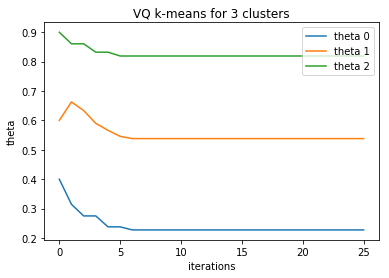

In [33]:
#Initialize 3 coin thetas between 0 and 1
init = [0.4, 0.6, 0.9]
n = 25 #number iterations
flips = [] #list of heads/total of input data
theta_list = [] #thetas after each k-means iteration
theta_list.append(init)

#Open file and store averages
fname = "seq_H_T.txt"
with open(fname) as f:
    for line in f:
        list_flips = list(map(int,line.split()))
        #print(list_flips)
        #print(mean(list_flips))
        flips.append(mean(list_flips))

#print(flips, "LENGTH:", len(flips))

#VQ k-means, assign clusters
theta = init
for i in range(0,n):
    clusters = [[] for i in range(0,3)]

    for flip in flips:
        min_dist = [0,0,0] #distance from centers
        for j in range(0, len(theta)):
            min_dist[j] = abs(theta[j] - flip)
        min_index = numpy.argmin(min_dist)
        #print(flip, min_index)
        clusters[min_index].append(flip)
    clusters = [clusters[k] or [theta[k]] for k in range(0,len(clusters))] #account for cluster with 0 members
    theta = list(map(mean, clusters))
    theta_list.append(theta)
# for i in range(0,len(theta_list)):
#     print(theta_list[i])

#Plotting
print("Final theta: ", theta)
plt.plot(theta_list)
plt.xlabel("iterations")
plt.ylabel("theta")
plt.title("VQ k-means for 3 clusters")
plt.legend(("theta 0", "theta 1", "theta 2"),loc='upper right')
plt.show()

<font color=red> self-assessment: </font>

### Part 2 - EM
Estimate the biases via EM given the sample sequences. Please check [this slide](https://repo.cslu.ohsu.edu/asgari/seqf18/blob/master/Lectures/lect1_week7.pdf) for how to implement it.


#### For Part 2 only:
* Submit your estimated biases at the end of 25th itration of both VQ and EM along with your codes. 
2. Check how quickly parameters of the model (biases in this example) converge by drawing  parametrs in a plot where the X axis is the number of iteration and Y axis is the estimated biased values. It should looks like this ![](em_theta.png)
3. Monitor the learning progress by drawing the log-likelihood score in a plot where the horizontal axis is the number of iteration. 
$$\textbf{X}=\{X_1,\cdots,X_N\} ~~;~~ \Theta=\{\theta_1,\theta_2,\theta_3\}$$ 
$$L(\Theta|\textbf{X})=\sum_{i=1}^N{\log\sum_{k=1}^3{\pi_k p(X_i|\theta_k)}}$$

4. Try out a few different initial probabilities and discuss its effect on the estimated parameters. 
5. Try out the estimated parameters obtained by VQ as initiale points to EM and discuss its benefits

## Reminder


For the HW, you are allowed to use python libraries such as numpy. However, you should write your own code from the scratch; i.e., you are not allowed to use built-in functions for VQ and EM  algorithms such as those that are available at scikit-learn.

Final theta:  [0.21996727487943488, 0.5253725996476263, 0.8111797998435983]


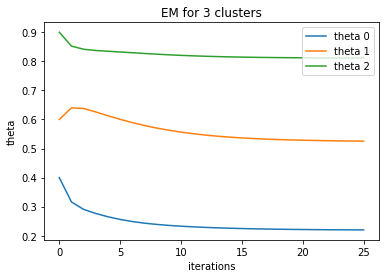

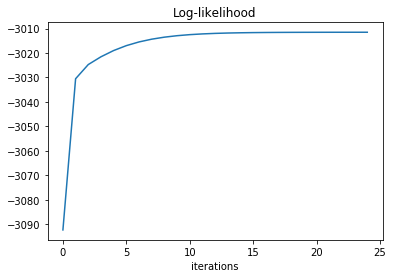

In [83]:
#Initialize 3 coin thetas between 0 and 1
init = [0.4, 0.6, 0.9]
#init = [0.22741935483870968, 0.5381578947368422, 0.8191964285714286]
#init = [0.8, 0.85, 0.95]
#init = [0.1, 0.2, 0.3]
theta = init
n = 25 #number iterations
pi = [1/3, 1/3, 1/3] #Initial probabilities equal
flips = [] #list of heads per each input line
theta_list = [] #thetas after each k-means iteration
loglike_list = [] #Log likelihood
theta_list.append(init)

#Open file and store # heads
fname = "seq_H_T.txt"
with open(fname) as f:
    for line in f:
        list_flips = list(map(int,line.split()))
        #print(list_flips)
        #print(sum(list_flips))
        flips.append(sum(list_flips))
#print(flips)

#EM loop
for i in range(0, n):
    #E-Step
    loglike = []
    sums = [[0,0] for i in range(0,len(theta))] #Number of [Heads, Tails], per coin
    pi_totals = [0,0,0] #accumulate pi partials

    for flip in flips:
        heads = flip
        tails = 20-heads #20 flips per sample
        pi_pxi = [] #pi.k * p(Xi | theta.k)
        denom = sum([(theta[i]**heads *(1-theta[i])**tails)*pi[i] for i in range(0, len(theta))])
        #For each coin, calculate P(coin|xi) and add in heads/tail contribution
        for j in range(0, len(theta)):
            numer = (theta[j]**heads *(1-theta[j])**tails) * pi[j]
            prob = numer/denom #Probability of coin.j, given X.i
            pi_totals[j] += prob
            #pi_pxi.append(pi[j]*prob) #<- Wrong
            pi_pxi.append(numer) #pi[j] * p(Xi | theta.j)
            
            sums[j][0] += prob*heads
            sums[j][1] += prob*tails
            #print("prob*heads", prob*heads)
        loglike.append(log(sum(pi_pxi)))
    #M-Step, recalculate thetas
    theta = [sums[i][0] / (sums[i][0] + sums[i][1]) for i in range(0, len(theta))] #heads / (heads+tails)
    theta_list.append(theta)
    #M-Step, recalculate pi
    pi = [pi_totals[n]/sum(pi_totals) for n in range(0,len(theta))]
    #print("thetas: ", theta)
    loglike_list.append(sum(loglike))

    
#Plotting
print("Final theta: ", theta)
plt.plot(theta_list)
plt.xlabel("iterations")
plt.ylabel("theta")
plt.title("EM for 3 clusters")
plt.legend(("theta 0", "theta 1", "theta 2"),loc='upper right')
plt.show()

plt.plot(loglike_list)
plt.title("Log-likelihood")
plt.xlabel("iterations")
plt.show()

## Discussion

### VQ k-means results
    Initial Theta            Final Theta (25th iteration)
    [0.1, 0.2, 0.3]          [0.20098039215686275, 0.48835616438356166, 0.8003968253968254]
    [0.4, 0.6, 0.9]          [0.22741935483870968, 0.5381578947368422, 0.8191964285714286]
    [0.8, 0.85, 0.95]        [0.22741935483870968, 0.5381578947368422, 0.8191964285714286]


### EM results

    Initial Theta            Final Theta
    [0.1, 0.2, 0.3]          [0.21596015062267704, 0.5168333020296884, 0.8088532509682547]
    [0.4, 0.6, 0.9]          [0.21996727487943488, 0.5253725996476263, 0.8111797998435983]
    [0.8, 0.85, 0.95]        [0.23646635614065445, 0.5680703816140247, 0.8245135562575406]
    [0.227, 0.538, 0.819]    [0.21919737058896163, 0.5236716398025771, 0.8107023491712637]

VQ results vary a noticeable amount (+/- 0.02) depending on the starting thetas, although many inputs can result in the exact same output due to the nature of the discrete hard-clustering. 

The soft-clustering of the EM algorithm allows us to converge more precisely, as partial weights are allowed for each sample.

Using the results of VQ as the EM input allows for a smoother convergence, as using "bad" values (i.e. starting values clustered together at one extreme of the range) means the values don't even converge by the 25th iteration (as with starting values of [0.8, 0.85, 0.95]). Using good initial values should allow us to converge in a more timely fashion.

<font color=red> self-assessment: </font>

In [37]:
#IGNORE-----------------------------
#TESTING GROUND
test1 = [[],[2],[]]
test2 = [100, 200, 300, 400, 500]

test1 = [test1[i] or [test2[i]] for i in range(len(test1))]
print(test1)

print( [[0,0] for i in range(0,3)] )

print(2**2)
test1 = [1, 2, 3]
test2 = [1, 2,]
test1.append(test2)
print(test1)

[[100], [2], [300]]
[[0, 0], [0, 0], [0, 0]]
4
[1, 2, 3, [1, 2]]
